درخواست ۸:


در این درخواست از ما می‌خواهد که لپتاپ‌های حال حاضر بازار ایران را برحسب شباهت ویژگی‌هایشان دسته‌بندی کنیم؛ بنابراین از یک الگوریتم یادگیری نظارت نشده استفاده می‌کنیم. اگر بخواهیم این دسته‌بندی را صرفا براساس ستون‌های عددی همچون قیمت، وزن لپتاپ و ظرفیت حافظه انجام دهیم باید از الگوریتم 
kmeans
 استفاده کنیم. و برای استفاده از ستون‌های غیرعددی باید از 
 Kmodes 
 استفاده کرد. و در نهایت در اینجا برای اینکه از هر دو نوع ستون‌های عددی و غیرعددی بهره بگیریم از الگوریتم یادگیری 
 kprototypes
  استفاده می‌کنیم.


In [80]:
import pandas as pd
import numpy as np

In [81]:
laptop_data = pd.read_csv('Laptops_final.csv')
laptop_data.describe()


,aprice,sprice,laptop_weight,Screen_size,Laptop_id
count,4.310000e+03,4.310000e+03,4310.000000,4310.00000,4310.000000
mean,4.221750e+07,4.220546e+07,6.968171,15.35634,88777.646404
std,3.088505e+07,2.881716e+07,95.308869,0.85742,41757.473279
min,9.566000e+06,9.666000e+06,1.000000,11.00000,18.000000
25%,2.055000e+07,2.219900e+07,1.780000,15.60000,62983.750000
50%,3.236400e+07,3.299900e+07,2.100000,15.60000,109735.500000
75%,5.190000e+07,5.100000e+07,2.300000,15.60000,122535.750000
max,2.200140e+08,2.203990e+08,2800.000000,18.40000,134663.000000


ابتدا لازم است برخی ستون‌هایی را که نیاز به تمیزکردن دارد را تمیز کنیم و در صورت امکان به فرمت عددی تبدیل کنیم:

In [82]:
laptop_data['RAM'] = laptop_data.RAM.str.split(" ",expand=True)[0]
laptop_data['RAM'] = laptop_data['RAM'].astype(float)

In [83]:
laptop_data['hard_disk']=laptop_data.hard_disk.str.split(" ",expand=True)[0]
laptop_data.drop(index=laptop_data[laptop_data['hard_disk']=='SATA'].index,inplace=True)
laptop_data['hard_disk'] = laptop_data['hard_disk'].astype(float)


In [84]:
laptop_data['graphic_memory'] = laptop_data.graphic_memory.str.split(" ",expand=True)[0]
laptop_data['graphic_memory'] = laptop_data['graphic_memory'].astype(float)


In [85]:
laptop_data['CPU_frequency'] = laptop_data.CPU_frequency.str.split(" ",expand=True)[0]
laptop_data['CPU_frequency'] = laptop_data['CPU_frequency'].astype(float)
laptop_data['cache_memory'] = laptop_data.cache_memory.str.split(" ",expand=True)[0]
laptop_data['cache_memory'] = laptop_data['cache_memory'].astype(float)


عنوان ستون‌های عددی و غیرعددی را ذخیره می‌کنیم تا در ادامه برای اجرای الگوریتم استفاده کنیم

In [86]:
cat_cols = ['manufactor','laptop_size','Screen_type','CPU_manufacturer','CPU_series']
num_cols = ['laptop_weight','Screen_size','RAM','hard_disk']


برخی از ستون‌هایی که نیازی به آن‌ها نداریم را حذف می‌کنیم:

In [87]:
laptop_data.drop(columns={'aprice','Screen_resolution','CPU_frequency','cache_memory','graphic_memory','sprice','laptop_type','CPU_model','RAM_type','internal_memory','graphic_manufacturer','graphic_model','Laptop_id'},inplace=True)

laptop_data.dropna(inplace=True)

In [88]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
std_scaler = preprocessing.StandardScaler()


laptop_data.loc[:, cat_cols] = laptop_data.loc[:, cat_cols].apply(le.fit_transform)

laptop_data.loc[:, num_cols] = std_scaler.fit_transform(laptop_data.loc[:, num_cols])


برای نمونه ابتدا برای حالت ۲ دسته‌ای اجرا می‌کنیم:

In [89]:
from kmodes.kprototypes import KPrototypes

kpro_cluster = KPrototypes(n_clusters=2, n_init = 1, verbose=1, n_jobs=-1)
kpro_cluster_pred = kpro_cluster.fit_predict(laptop_data.drop(columns={'name','ename'}), \
                                             categorical=[laptop_data.columns.get_loc(c) for c in cat_cols] )

Initialization method and algorithm are deterministic. Setting n_init to 1.


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 590, ncost: 77972791.18269968
Run: 1, iteration: 2/100, moves: 260, ncost: 75593234.14435443
Run: 1, iteration: 3/100, moves: 32, ncost: 75566380.36975548
Run: 1, iteration: 4/100, moves: 0, ncost: 75566380.36975548


پس لپتاپ‌ها را به دو دسته تقسیم می‌کند که با توجه به مقدار میانگین، تعداد دو دسته تقریبا یکسان شده است

In [90]:
# Predicted Clusters
print(np.unique(kpro_cluster_pred))
print(kpro_cluster_pred.mean())

[0 1]
0.5267193308550185


حال الگوریتم را به ازای تعداد دسته‌های ۱ تا ۱۵ اجرا می‌کنیم و با بررسی نمودار مجموع فواصل، تعداد دسته بهینه را تعیین می کنیم:

In [91]:
cost = []
for num_clusters in list(range(1,15)):
    kpro = KPrototypes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1, n_jobs=-1)
    kpro.fit_predict(laptop_data.drop(columns={'name','ename'}), \
                      categorical = [laptop_data.columns.get_loc(c) for c in cat_cols])
    cost.append(kpro.cost_)
    print('\n-----')

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 288375996.0301212

-----
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 249, ncost: 75614434.079571
Run: 1, iteration: 2/100, moves: 34, ncost: 75567538.49465193
Run: 1, iteration: 3/100, moves: 5, ncost: 75566380.36975548
Run: 1, iteration: 4/100, moves: 0, ncost: 75566380.36975548

-----
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 370, ncost: 47737555.235263385
Run: 1, iteration: 2/100, moves: 280, ncost: 45722668.47599243
Run: 1, iteration: 3/100, moves: 151, ncost: 45266769.346946076
Run: 1, iteration: 4/

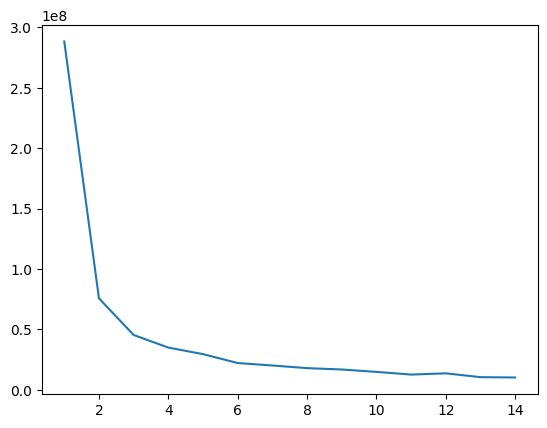

In [92]:
import matplotlib.pyplot as plt

y = np.array([i for i in range(1,15)])
plt.plot(y,cost)

در نتیجه الگوریتم را به ازای تعداد دسته ۶ اجرا می‌کنیم و نتیجه را به صورت ستون به داده اصلی اضافه می‌کنیم:

In [93]:
kpro_cluster = KPrototypes(n_clusters=6, init = "Cao", n_init = 1, verbose=1)
kpro_cluster_pred = kpro_cluster.fit_predict(laptop_data.drop(columns={'name','ename'}), \
                      categorical = [laptop_data.columns.get_loc(c) for c in cat_cols] )

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters


Starting iterations...
Run: 1, iteration: 1/100, moves: 750, ncost: 22306748.690774858
Run: 1, iteration: 2/100, moves: 209, ncost: 22041839.208562598
Run: 1, iteration: 3/100, moves: 82, ncost: 21981343.94921353
Run: 1, iteration: 4/100, moves: 18, ncost: 21977914.864881042
Run: 1, iteration: 5/100, moves: 2, ncost: 21977822.655124817
Run: 1, iteration: 6/100, moves: 0, ncost: 21977822.655124817


In [94]:
print(len(kpro_cluster_pred))
print(kpro_cluster_pred.mean())

4304
2.345724907063197


ستون دسته‌بندی را به داده اضافه می‌کنیم 

In [95]:
clustersDf = pd.DataFrame(kpro_cluster_pred)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([laptop_data, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index'], axis = 1)

مثلا مجموعه لپتاپ‌های دسته ۵ می‌شود:

In [96]:
combinedDf[combinedDf['cluster_predicted']==5]

,manufactor,name,ename,laptop_size,laptop_weight,Screen_size,Screen_type,CPU_manufacturer,CPU_series,RAM,hard_disk,cluster_predicted
0,1,\nMacBook Air اپل 13 اینچ مدل MGND3 2020 پرداز...,\nApple MacBook Air MGND3 2020 - 13 inch Laptop\n,541,-0.059613,-2.396636,127,1,48,-0.470128,0.271519,5.0
1,1,\nMacBook Air اپل 13 اینچ مدل MGN63 2020 پرداز...,\nApple MacBook Air MGN63 2020 M1 256 - 13 inc...,526,-0.059613,-2.396636,200,1,48,-0.470128,0.271519,5.0
2,1,\nلپ تاپ اپل 14 اینچ مدل Mac Book Pro 14inch M...,\nApple MacBook Pro 14‑inch MKGP3 M1 Pro 16GB ...,558,-0.056363,-1.347525,189,1,50,0.509030,1.468794,5.0
3,1,\nلپ تاپ اپل 14 اینچ مدل Mac Book Pro 14inch M...,\nApple MacBook Pro 14‑inch MKGR3 M1 Pro 16GB ...,558,-0.056363,-1.347525,189,1,50,0.509030,1.468794,5.0
4,1,\nلپ تاپ اپل 14 اینچ مدل Mac Book Pro 14inch M...,\nApple MacBook Pro 14‑inch MKGQ3 M1 Pro 16GB ...,558,-0.056363,-1.347525,189,1,50,0.509030,-0.921080,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3917,0,\nلپ تاپ ایسر اسپایر مدل ای 5 با پردازنده i5\n,\nAspire-E5-571G-Core-i5-4GB-500GB-1GB\n,202,-0.046925,0.284425,146,3,29,-0.959707,1.412672,5.0
4121,0,\nلپ تاپ ایسر مدل V15 Nitro VN7-592G-79T2 با پ...,\nAspire V15 Nitro VN7-592G-79T2 Core i7 12GB ...,255,-0.049022,0.284425,123,3,30,0.019451,-0.327119,5.0
4138,0,\nلپ تاپ ایسر اسپایر مدل Spin 5-SP513 با پرداز...,\nSpin 5-SP513 Core i5 8GB 512GB SSD Intel Tou...,195,-0.055314,-2.396636,127,3,29,-0.470128,1.468794,5.0
4171,0,\nلپ تاپ 15 اینچی ایسر مدل Aspire A315\n,\nAspire A315 Core i5 8250U 8GB 1TB 256GB SSD ...,823,-0.051120,0.284425,212,3,29,-0.470128,0.271519,5.0


و برای ۶۱۸ مدل لپتاپی که در داده‌های شرکت لوتک داشتیم دسته‌بندی ۶ دسته‌ای را اعمال می‌کنیم:

In [69]:
all_data = pd.read_csv('sales_data.csv')
all_data.drop_duplicates(subset=['Model_Name'],inplace=True)

In [70]:
len(all_data['Screen'].unique())

31

In [71]:
all_data[['Screen_Size','maz1']] = all_data.Screen_Size.str.split('"',expand=True)
all_data['Screen_Size']=all_data['Screen_Size'].astype('float')

all_data[['RAM','maz2']] = all_data.RAM.str.split("G",expand=True)
all_data['RAM'] = all_data['RAM'].astype('float')
all_data[['laptop_weight','maz3']] = all_data.Weight.str.split("k",expand=True)
all_data['laptop_weight'] = all_data['laptop_weight'].astype('float')

all_data['CPU_manufacturer'] = all_data.CPU.str.split(" ",expand=True)[0]
#all_data['CPU_manufacturer'].replace('Samsung','other',inplace=True)
#all_data['CPU_manufacturer'].replace('Intel','INTEL',inplace=True)
all_data['graphic_manufacturer'] = all_data.GPU.str.split(" ",expand=True)[0]
#all_data['graphic_manufacturer'].replace('ARM','Other',inplace=True)

In [72]:
all_data.columns

Index(['Order_ID', 'Branch', 'Order_Date', 'Order_Priority', 'Manufacturer',
       'Model_Name', 'Category', 'Screen_Size', 'Screen', 'CPU', 'RAM',
       'Storage', 'GPU', 'OS', 'OS_Version', 'Weight', 'Price', 'Quantity',
       'Discount', 'Total_Price', 'Profit', 'Ship_Duration', 'maz1', 'maz2',
       'laptop_weight', 'maz3', 'CPU_manufacturer', 'graphic_manufacturer'],
      dtype='object')

In [73]:
all_data = all_data[['Manufacturer','Category','Screen_Size','Screen','CPU_manufacturer','RAM','laptop_weight','graphic_manufacturer','Price']]

In [74]:
cat_cols = ['Manufacturer','Category','Screen','CPU_manufacturer','graphic_manufacturer']
num_cols = ['Screen_Size','laptop_weight','Price','RAM','']

In [75]:
kpro_cluster_pred_org = kpro_cluster.fit_predict(all_data, \
                      categorical = [all_data.columns.get_loc(c) for c in cat_cols] )

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...


Run: 1, iteration: 1/100, moves: 59, ncost: 2.6138179073932748e+16
Run: 1, iteration: 2/100, moves: 56, ncost: 2.1638156585432804e+16
Run: 1, iteration: 3/100, moves: 28, ncost: 1.8544068371636828e+16
Run: 1, iteration: 4/100, moves: 25, ncost: 1.5748086564625378e+16
Run: 1, iteration: 5/100, moves: 31, ncost: 1.4767220318060756e+16
Run: 1, iteration: 6/100, moves: 19, ncost: 1.4078375254783324e+16
Run: 1, iteration: 7/100, moves: 6, ncost: 1.3950706677932286e+16
Run: 1, iteration: 8/100, moves: 5, ncost: 1.3865758383769536e+16
Run: 1, iteration: 9/100, moves: 17, ncost: 1.3733449268697218e+16
Run: 1, iteration: 10/100, moves: 10, ncost: 1.3701885550234914e+16
Run: 1, iteration: 11/100, moves: 5, ncost: 1.368879924968626e+16
Run: 1, iteration: 12/100, moves: 1, ncost: 1.3687856268035926e+16
Run: 1, iteration: 13/100, moves: 0, ncost: 1.3687856268035926e+16


In [76]:
clustersDf_Lotech = pd.DataFrame(kpro_cluster_pred_org)
clustersDf_Lotech.columns = ['cluster_predicted']
clustersDf_Lotech = pd.concat([all_data, clustersDf_Lotech], axis = 1).reset_index()
clustersDf_Lotech = clustersDf_Lotech.drop(['index'], axis = 1)

In [77]:
clustersDf_Lotech

,Manufacturer,Category,Screen_Size,Screen,CPU_manufacturer,RAM,laptop_weight,graphic_manufacturer,Price,cluster_predicted
0,Dell,Notebook,15.6,Full HD 1920x1080,Intel,8.0,2.18,AMD,3450000.0,5.0
1,Lenovo,2 in 1 Convertible,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel,8.0,1.30,Intel,3400000.0,5.0
2,Lenovo,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel,8.0,2.60,Nvidia,44900000.0,1.0
3,Dell,Ultrabook,13.3,IPS Panel Full HD 1920x1080,Intel,8.0,1.40,AMD,12550000.0,3.0
4,Acer,Notebook,15.6,Full HD 1920x1080,Intel,4.0,2.23,Nvidia,2050000.0,5.0
...,...,...,...,...,...,...,...,...,...,...
959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [79]:
clustersDf_Lotech['cluster_predicted'].mean()

3.661812297734628

و نمودار زیر را در مقایسه قیمت و وزن با دسته‌بندی اجرا شده رسم کرده‌ایم: